In [ ]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 135kB/s 
     |████████████████████████████████| 6.8MB 7.4MB/s 
     |████████████████████████████████| 983kB 40.9MB/s 
     |████████████████████████████████| 266kB 58.9MB/s 
     |████████████████████████████████| 1.3MB 47.9MB/s 
     |████████████████████████████████| 1.2MB 47.3MB/s 
     |████████████████████████████████| 471kB 58.5MB/s 
     |████████████████████████████████| 2.9MB 49.1MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
  Created wheel for ktrain: filename=ktrain-0.25.3-cp36-none-any.whl size=25276312 sha256=1341a9f3b145c16be1f1ef271c2707f4784244758df8ea66bc69cdd8c1848f31
  Stored in directory: /root/.cache/pip/wheels/86/cd/9c/ad53b98a3eccf4ddeddccfce99d353781f206a1ac4287ca721
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993194 sha256=eba055a83c0c46ae74226c7c2ccce334d181b1eb83319215c8a6584333bbaf24
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40

In [ ]:
import ktrain
from ktrain import text
import pandas as pd
import numpy as np
from sklearn.utils import shuffle, resample

## Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
news = pd.read_excel("/content/drive/MyDrive/Masterarbeit/Crawler/data/FinalDataset/Ablation02/CleanData_FinalDataset_ForModel_Ablation2.xlsx", index_col=0)

In [ ]:
# Get the same train and test data
def split_df_in_train_test(df):
    df = df.reset_index()
    split_point = int(np.round(df.shape[0]) * 0.8)
    df_train = df.loc[:split_point-1,:]
    df_test = df.loc[split_point:,:]
    return df_train, df_test

In [ ]:
n_samples = 6000

In [ ]:
left_FE = resample(shuffle(news[(news["label"]=="links") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)
center_FE = resample(shuffle(news[(news["label"]=="central") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)
right_FE = resample(shuffle(news[(news["label"]=="rechts") & (news.maintext.str.split().str.len()<512)], random_state=42), \
         random_state=42, n_samples=n_samples)

In [ ]:
train = pd.concat([split_df_in_train_test(left_FE)[0], \
    split_df_in_train_test(center_FE)[0], \
    split_df_in_train_test(right_FE)[0]])

In [ ]:
test =  pd.concat([split_df_in_train_test(left_FE)[1], \
    split_df_in_train_test(center_FE)[1], \
    split_df_in_train_test(right_FE)[1]])

In [ ]:
x_train = train["maintext"].to_list()
y_train = train["label"].to_list()
x_test = test["maintext"].to_list()
y_test = test["label"].to_list()

In [ ]:
class_names = list(train["label"].unique())

## Build the model

In [ ]:
model_name = "bert-base-german-cased"

In [ ]:
t = text.Transformer(model_name, maxlen=512, classes= class_names)

/usr/local/lib/python3.6/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


In [ ]:
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)

preprocessing train...
language: de
train sequence lengths:
	mean : 213
	95percentile : 466
	99percentile : 503


/usr/local/lib/python3.6/dist-packages/ktrain/utils.py:589: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 215
	95percentile : 462
	99percentile : 502


In [ ]:
trn.x

array([[[    3,  2280,  1733, ...,  4841,  9349,     4],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,   173,   798, ...,  2239,   144,     4],
        [    1,     1,     1, ...,     1,     1,     1],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,  2912, 26935, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       ...,

       [[    3,   233,  8581, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,   346,  5837, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0]],

       [[    3,  2261,  4532, ...,     0,     0,     0],
        [    1,     1,     1, ...,     0,     0,     0],
        

In [ ]:
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

In [ ]:
model.loss

In [ ]:
learner.freeze()

simulating training for different learning rates... this may take a few moments...
1800/1800 [==============================] - 631s 343ms/step - loss: 1.9070 - accuracy: 0.3544


done.
Visually inspect loss plot and select learning rate associated with falling loss


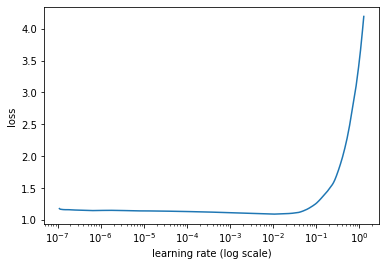

In [ ]:
learner.lr_find(show_plot=True, max_epochs=1)

In [ ]:
optimal_lr = learner.lr_estimate()[1]

In [ ]:
print(optimal_lr)

0.0010102852247655392


In [ ]:
learner.fit(0.00001, 7)

Epoch 1/7
1800/1800 [==============================] - 1956s 1s/step - loss: 0.6816 - accuracy: 0.6917 - val_loss: 0.2738 - val_accuracy: 0.8981
Epoch 2/7
1800/1800 [==============================] - 1941s 1s/step - loss: 0.1932 - accuracy: 0.9308 - val_loss: 0.2133 - val_accuracy: 0.9300
Epoch 3/7
1800/1800 [==============================] - 1942s 1s/step - loss: 0.0784 - accuracy: 0.9751 - val_loss: 0.2293 - val_accuracy: 0.9361
Epoch 4/7
1800/1800 [==============================] - 1941s 1s/step - loss: 0.0420 - accuracy: 0.9859 - val_loss: 0.2160 - val_accuracy: 0.9381
Epoch 5/7
1800/1800 [==============================] - 1941s 1s/step - loss: 0.0292 - accuracy: 0.9895 - val_loss: 0.2561 - val_accuracy: 0.9428
Epoch 6/7
1800/1800 [==============================] - 1941s 1s/step - loss: 0.0188 - accuracy: 0.9927 - val_loss: 0.2961 - val_accuracy: 0.9322
Epoch 7/7
1800/1800 [==============================] - 1941s 1s/step - loss: 0.0251 - accuracy: 0.9914 - val_loss: 0.2731 - val_ac

In [ ]:
learner.validate(class_names=class_names)

              precision    recall  f1-score   support

       links       0.91      0.93      0.92      1200
     central       0.97      0.94      0.95      1200
      rechts       0.94      0.95      0.94      1200

    accuracy                           0.94      3600
   macro avg       0.94      0.94      0.94      3600
weighted avg       0.94      0.94      0.94      3600



array([[1111,   33,   56],
       [  48, 1133,   19],
       [  56,    8, 1136]])